In [1]:
#Hybrid coffee leaf disease detection using deep learning architecture

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
from collections import Counter

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from cycler import cycler
import textwrap

In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

# Create helper functions
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [4]:
# Function to create DataFrame from image dataset
def create_image_dataframe(dataset_path: str) -> pd.DataFrame:
    image_dir = Path(dataset_path)
    filepaths = list(image_dir.glob(r'**/*.JPG')) + \
                list(image_dir.glob(r'**/*.jpg')) + \
                list(image_dir.glob(r'**/*.png')) + \
                list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths_series, labels_series], axis=1)
    return image_df

In [5]:
# Load and preprocess the dataset
train_dataset = "coffeedata"
train_df = create_image_dataframe(train_dataset)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Change class_mode to 'categorical'
    subset='training'
)

Found 93448 validated image filenames belonging to 5 classes.


In [6]:
# Define the paths to the test and train datasets
test_dataset = "coffeedata"
train_dataset = "coffeedata"

# Create dataframes for the test and train datasets
test_df = create_image_dataframe(test_dataset)
train_df = create_image_dataframe(train_dataset)

# Access the test dataframe correctly
print(test_df)  # This will print the contents of the test dataframe

                                   Filepath        Label
0          coffeedata\Cerscospora\4 (1).jpg  Cerscospora
1         coffeedata\Cerscospora\4 (10).jpg  Cerscospora
2        coffeedata\Cerscospora\4 (100).jpg  Cerscospora
3       coffeedata\Cerscospora\4 (1000).jpg  Cerscospora
4       coffeedata\Cerscospora\4 (1001).jpg  Cerscospora
...                                     ...          ...
116805         coffeedata\Phoma\6 (993).jpg        Phoma
116806         coffeedata\Phoma\6 (994).jpg        Phoma
116807         coffeedata\Phoma\6 (995).jpg        Phoma
116808         coffeedata\Phoma\6 (996).jpg        Phoma
116809         coffeedata\Phoma\6 (997).jpg        Phoma

[116810 rows x 2 columns]


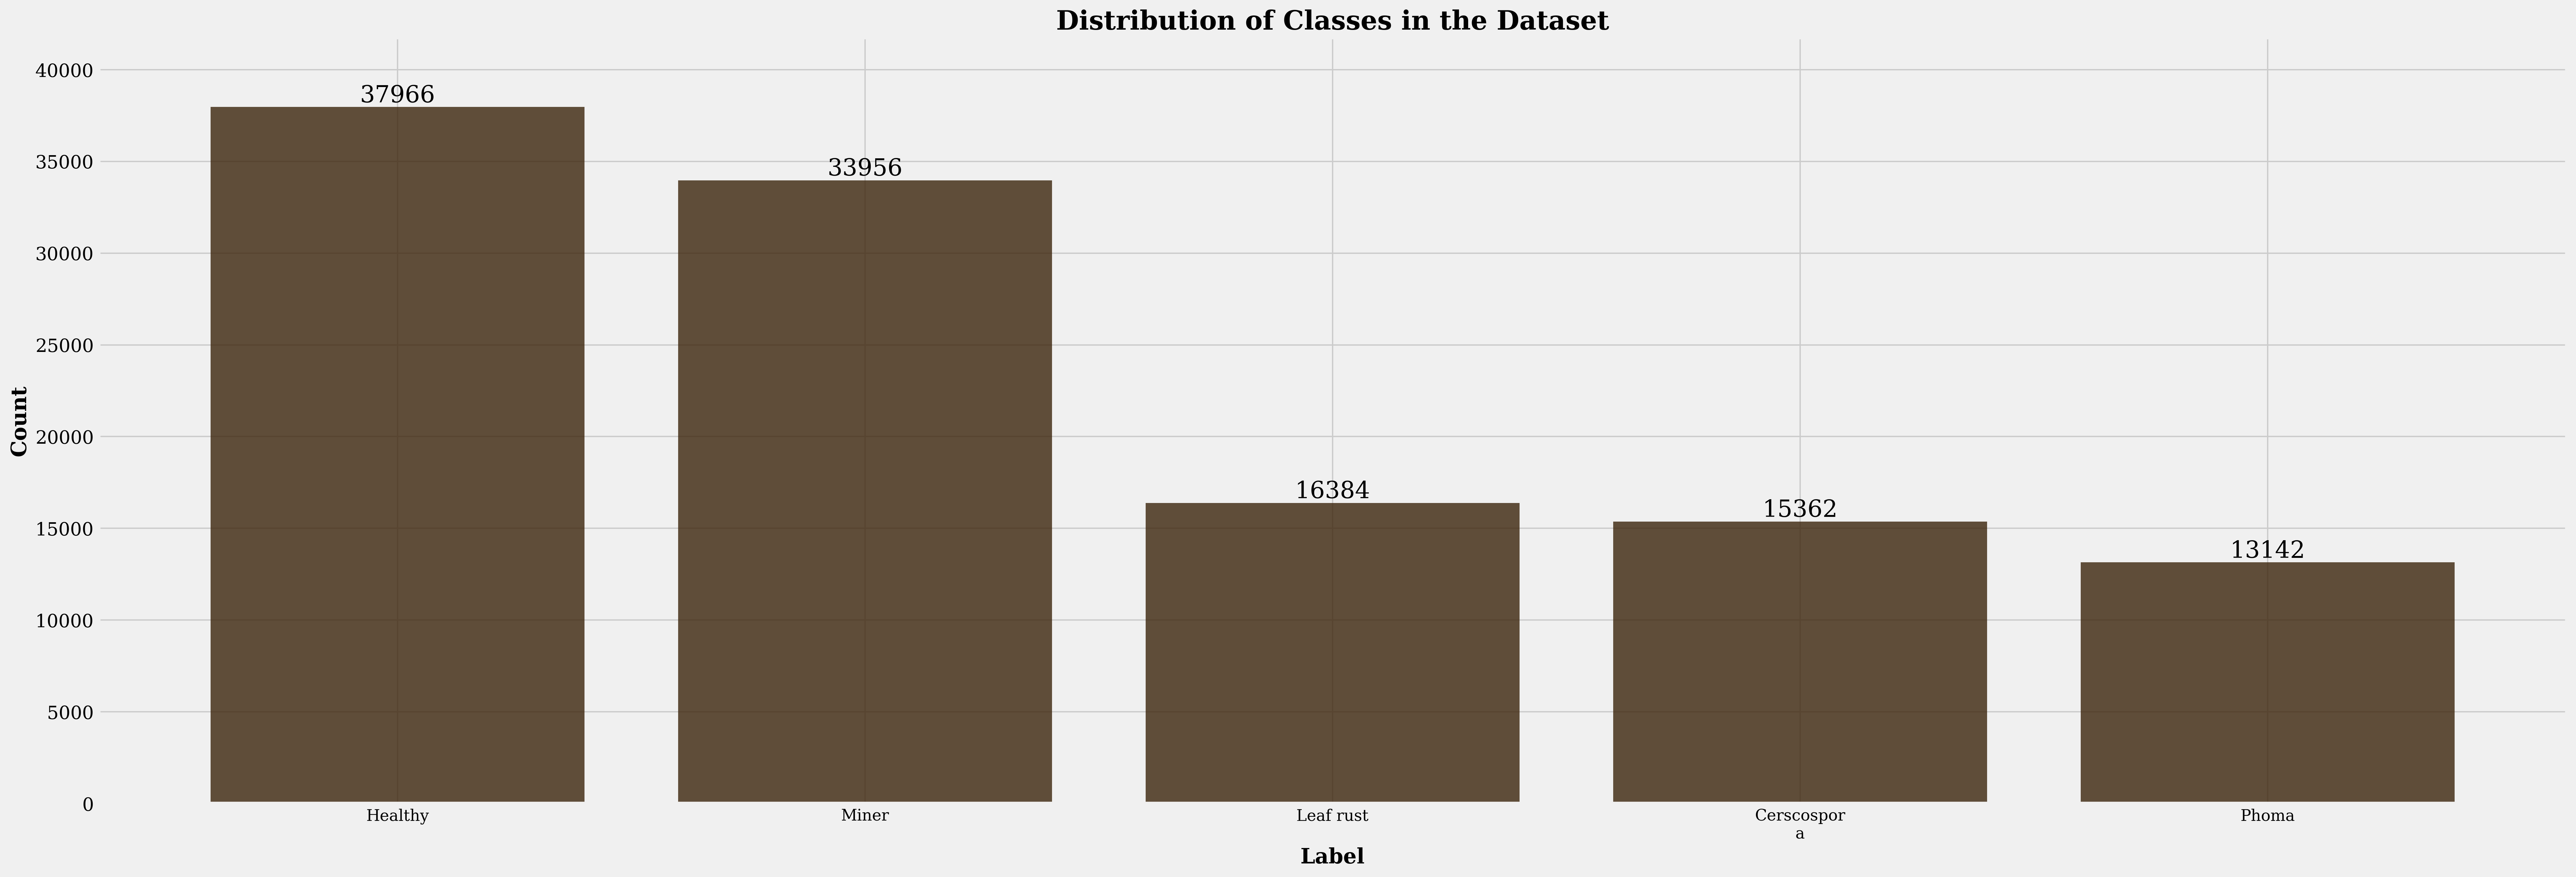

In [7]:
import matplotlib.pyplot as plt
from cycler import cycler
import textwrap

plt.style.use('fivethirtyeight')

# Get the labels
label_counts = train_df['Label'].value_counts()[:]

# Create a cycler object using the desired colors
color_cycler = cycler(color=["#3B240B"])  # Darker coffee brown color

# Set the property cycle of the axes to the created cycler object
plt.rc('axes', prop_cycle=color_cycler)

# Other styling options
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

plt.figure(figsize=(30, 10), dpi=300)  # Increase figure size
bars = plt.bar(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Distribution of Classes in the Dataset', fontsize=20, fontweight='bold')
plt.xlabel('Label', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

# Wrap x-labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, 10)) for label in label_counts.index]
plt.xticks(range(len(wrapped_labels)), wrapped_labels, fontsize=12, ha='center')  # Change alignment to 'center'

plt.yticks(fontsize=14)

# Adjust y limit to avoid overlapping
plt.ylim(0, max(label_counts) * 1.1)  # Set y limit 10% higher than the max value

# Add value annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.show()


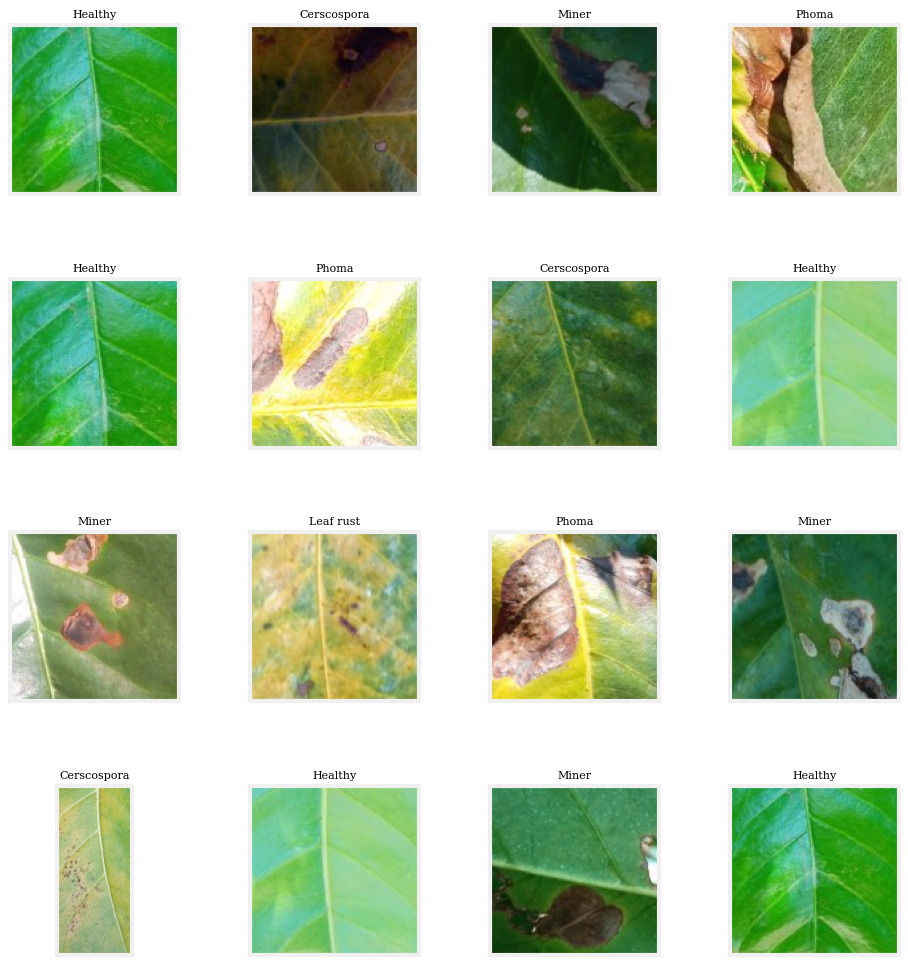

In [8]:
# Visualization
# Set title size and figure background color
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['figure.facecolor'] = 'white'

# Display 16 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    title = train_df.Label[random_index[i]]
    ax.set_title("\n".join(textwrap.wrap(title, 20)), fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

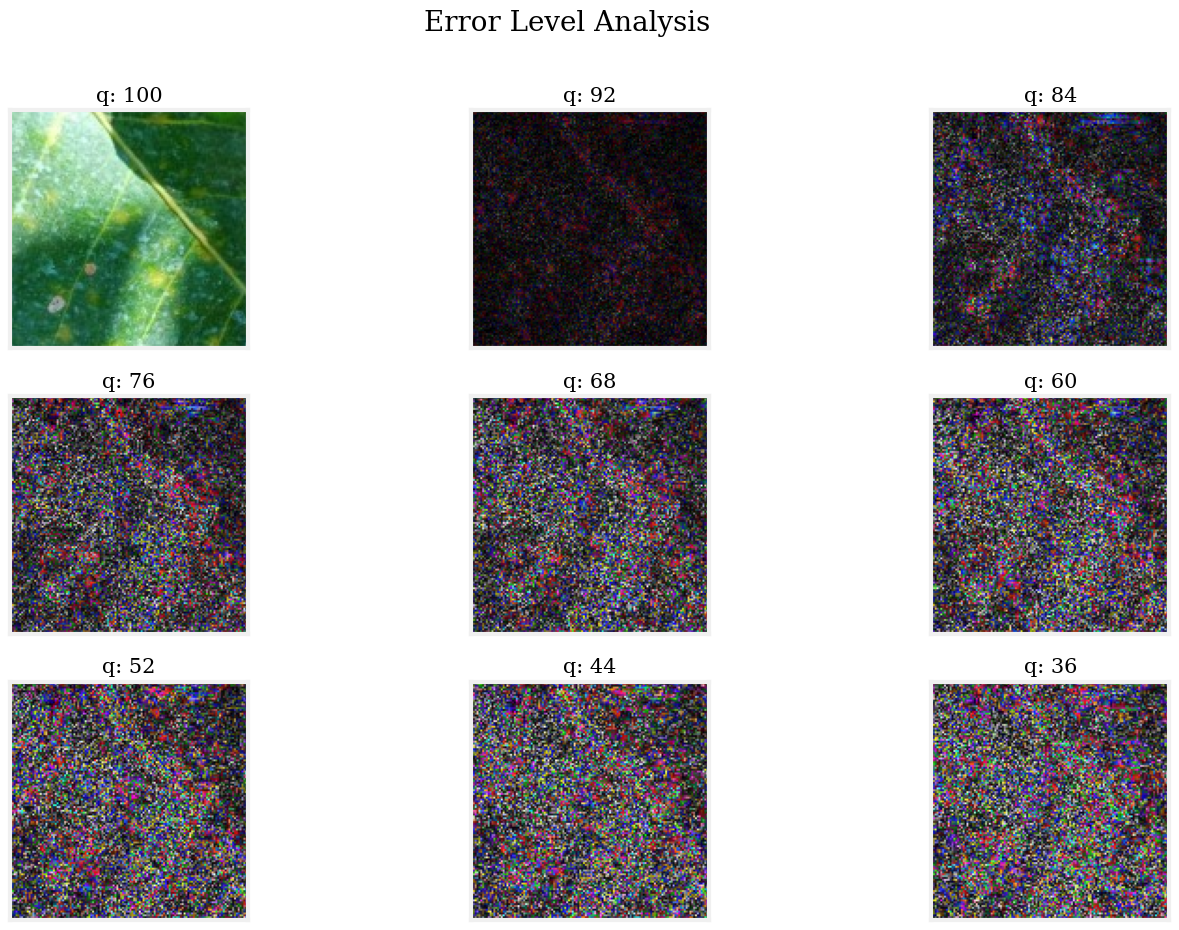

In [9]:
#Computing Error Rate Analysis
import cv2
from PIL import Image, ImageChops, ImageEnhance
from pathlib import Path
import random

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Read compressed image
    compressed_img = cv2.imread(temp_filename)

    # Get absolute difference between original and compressed images and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = list(Path(path).glob(f'*.{extension}'))
    else:
        items = list(Path(path).glob('*'))
        
    if not items:
        raise FileNotFoundError("No files found in the specified directory with the given extension.")
        
    p = random.choice(items)
    return p.as_posix()

# View random sample from the dataset
p = random_sample('coffeedata/Cerscospora')
if p is not None:
    orig = cv2.imread(p)
    if orig is not None:
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
        init_val = 100
        columns = 3
        rows = 3

        fig=plt.figure(figsize=(15, 10))
        fig.suptitle('Error Level Analysis', fontsize=20)  # Add super title
        for i in range(1, columns*rows +1):
            quality=init_val - (i-1) * 8
            img = compute_ela_cv(path=p, quality=quality)
            if i == 1:
                img = orig.copy()
            ax = fig.add_subplot(rows, columns, i)
            ax.title.set_text(f'q: {quality}')
            plt.imshow(img)
            ax.set_xticks([])  # Remove x-ticks
            ax.set_yticks([])  # Remove y-ticks
        plt.show()
    else:
        print(f"Error: Failed to load the image '{p}'.")
else:
    print("Error: No file found in the specified directory.")

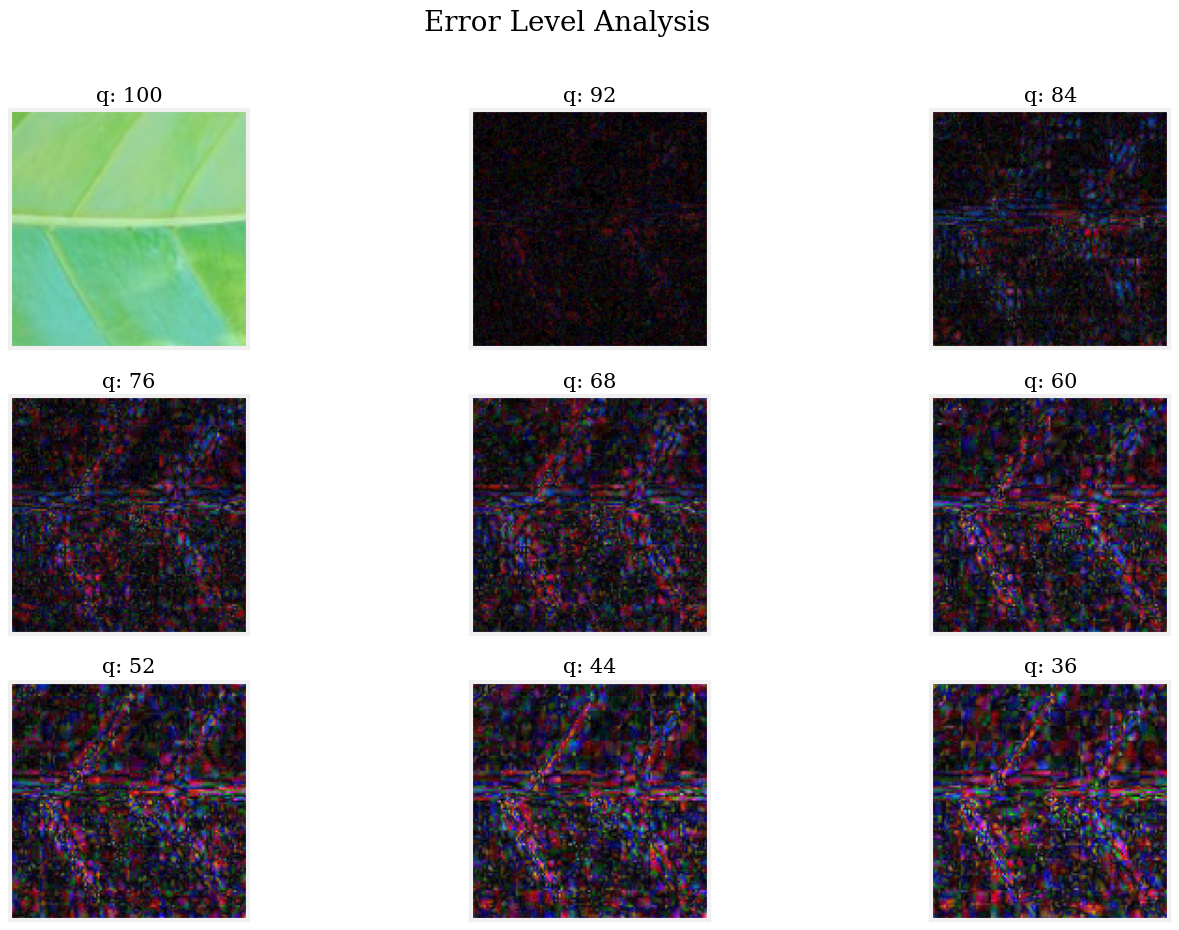

In [10]:
# View random sample from the dataset
p = random_sample('coffeedata/Healthy')
if p is not None:
    orig = cv2.imread(p)
    if orig is not None:
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
        init_val = 100
        columns = 3
        rows = 3

        fig=plt.figure(figsize=(15, 10))
        fig.suptitle('Error Level Analysis', fontsize=20)  # Add super title
        for i in range(1, columns*rows +1):
            quality=init_val - (i-1) * 8
            img = compute_ela_cv(path=p, quality=quality)
            if i == 1:
                img = orig.copy()
            ax = fig.add_subplot(rows, columns, i)
            ax.title.set_text(f'q: {quality}')
            plt.imshow(img)
            ax.set_xticks([])  # Remove x-ticks
            ax.set_yticks([])  # Remove y-ticks
        plt.show()
    else:
        print(f"Error: Failed to load the image '{p}'.")
else:
    print("Error: No file found in the specified directory.")

In [11]:
#datapreprocessing
# Separate into train and test data
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

from sklearn.model_selection import train_test_split

# Shuffle your dataframe for randomness
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Stratified Split
train_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df['Label'])

# Now use train_df with train_images generator and val_df with val_images generator without the subset parameter
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 81767 validated image filenames belonging to 5 classes.
Found 35043 validated image filenames belonging to 5 classes.
Found 116810 validated image filenames belonging to 5 classes.


In [12]:
# Function to get distribution from the generator
def get_distribution(generator):
    # Counting occurrences for each class
    counter = Counter(generator.labels)
    max_val = float(max(counter.values()))
    return {k: v/max_val for k, v in counter.items()}

# Print distributions
print("Training Data Distribution:", get_distribution(train_images))
print("Validation Data Distribution:", get_distribution(val_images))

Training Data Distribution: {0: 0.4046131848284166, 2: 0.4315547862733293, 1: 1.0, 3: 0.8943783865141481, 4: 0.34617700180614086}
Validation Data Distribution: {3: 0.8943810359964881, 1: 1.0, 0: 0.40465320456540826, 4: 0.3460930640913082, 2: 0.4315188762071993}


In [13]:
# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
])

In [14]:
#size of data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set constants
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# Load the dataset into a DataFrame
dataset_path = "coffeedata"
data_df = create_image_dataframe(dataset_path)  # Assuming you have already defined create_image_dataframe function

# Display size of each class
class_sizes = data_df['Label'].value_counts()
print("Size of each class:")
print(class_sizes)

# Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create data generators for training, validation, and testing sets
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,  # Example: additional augmentation parameters
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Create generator objects
train_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print the size of each set
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

Size of each class:
Healthy        37966
Miner          33956
Leaf rust      16384
Cerscospora    15362
Phoma          13142
Name: Label, dtype: int64
Found 74758 validated image filenames belonging to 5 classes.
Found 18690 validated image filenames belonging to 5 classes.
Found 23362 validated image filenames belonging to 5 classes.
Training set size: 74758
Validation set size: 18690
Testing set size: 23362


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Define data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True  
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Define paths to your datasets
train_dataset = "coffeedata"
val_dataset = "coffeedata"
test_dataset = "coffeedata"

# Define batch size
BATCH_SIZE = 32

# Create data generators for training, validation, and testing sets
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dataset,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model for fewer epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=2, #reduced model generator
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc}")

Found 58549 images belonging to 5 classes.
Found 58549 images belonging to 5 classes.
Found 58549 images belonging to 5 classes.



Epoch 1/2



1830/1830 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9833
Epoch 1: val_accuracy improved from -inf to 0.99939, saving model to best_model.h5


C:\Users\Tanusha\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1830/1830 [==============================] - 13347s 7s/step - loss: 0.0495 - accuracy: 0.9833 - val_loss: 0.0022 - val_accuracy: 0.9994 - lr: 0.0100
Epoch 2/2
1830/1830 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9964
Epoch 2: val_accuracy improved from 0.99939 to 0.99993, saving model to best_model.h5
1830/1830 [==============================] - 7264s 4s/step - loss: 1.7267e-04 - accuracy: 0.9999
Test Accuracy: 0.9999316930770874


In [16]:
model.save_weights('coffee_leaf_disease_ResNet50.h5')

In [17]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)

# Convert accuracy to percentage
accuracy_percentage = accuracy * 100

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy: {:.2f}%".format(accuracy_percentage))

1830/1830 [==============================] - 6001s 3s/step - loss: 1.7267e-04 - accuracy: 0.9999
Test Loss: 0.00017266954819206148
Test Accuracy: 99.99%


In [18]:
import os

file_size = os.path.getsize('coffee_leaf_disease_ResNet50.h5') / (1024 * 1024)  # Convert bytes to MB
print(f"Model file size: {file_size:.2f} MB")

Model file size: 94.41 MB


In [19]:
total_params = model.count_params()
print(f"Total parameters: {total_params}")

Total parameters: 24639365


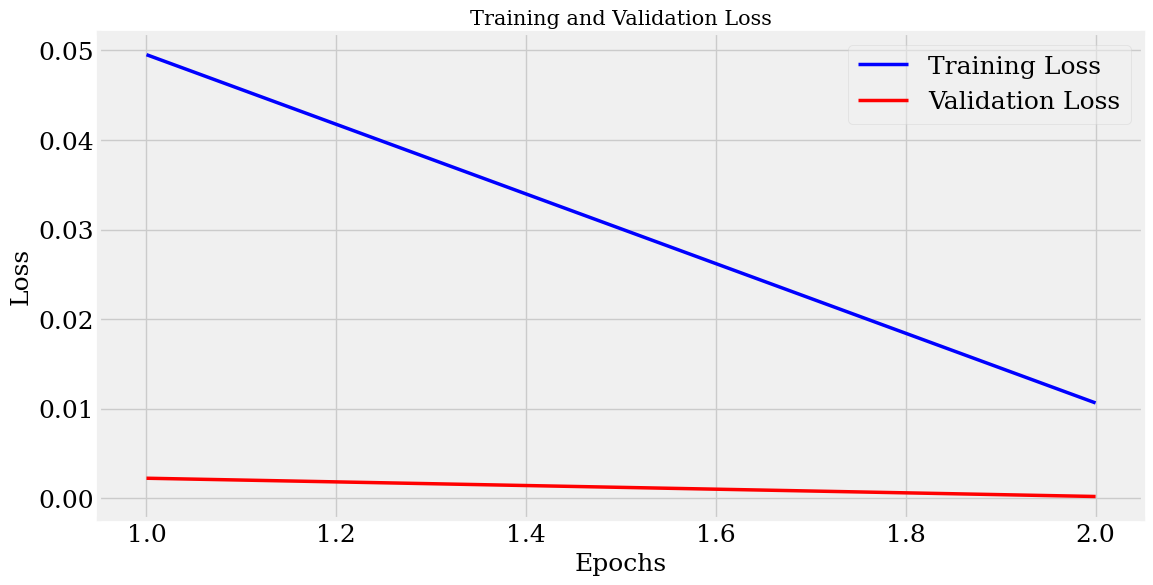

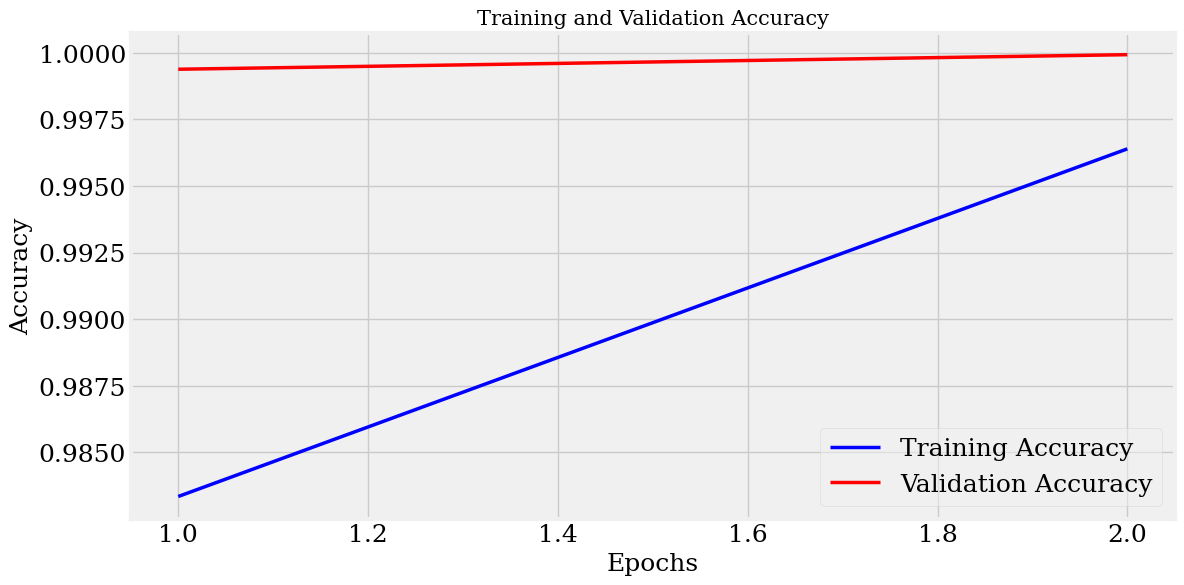

In [20]:
#Visualizing loss curves

import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

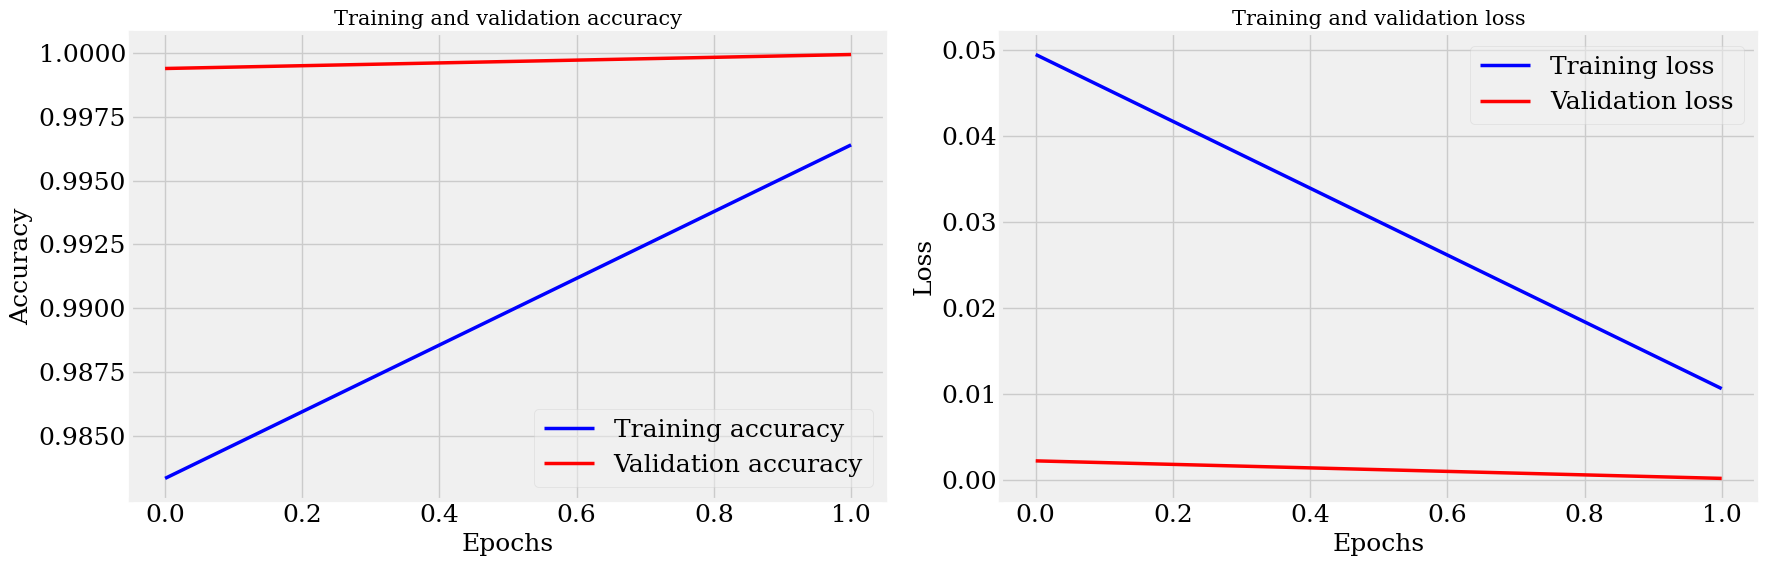

In [21]:
# Extracting metrics from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# Plot accuracy and loss
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot F1-score
if 'f1_score' in history.history and 'val_f1_score' in history.history:
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, f1, 'b', label='Training F1-score')
    plt.plot(epochs, val_f1, 'r', label='Validation F1-score')
    plt.title('Training and validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.legend()
    plt.show()

In [22]:
#Making predictions on the Test Data
# Predict the labels of the test images
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

# Map the labels to class names
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Display the first 5 predictions
print(f'The first 5 predictions: {pred[:5]}')

1830/1830 [==============================] - 5944s 3s/step
The first 5 predictions: ['Cerscospora', 'Cerscospora', 'Cerscospora', 'Cerscospora', 'Cerscospora']


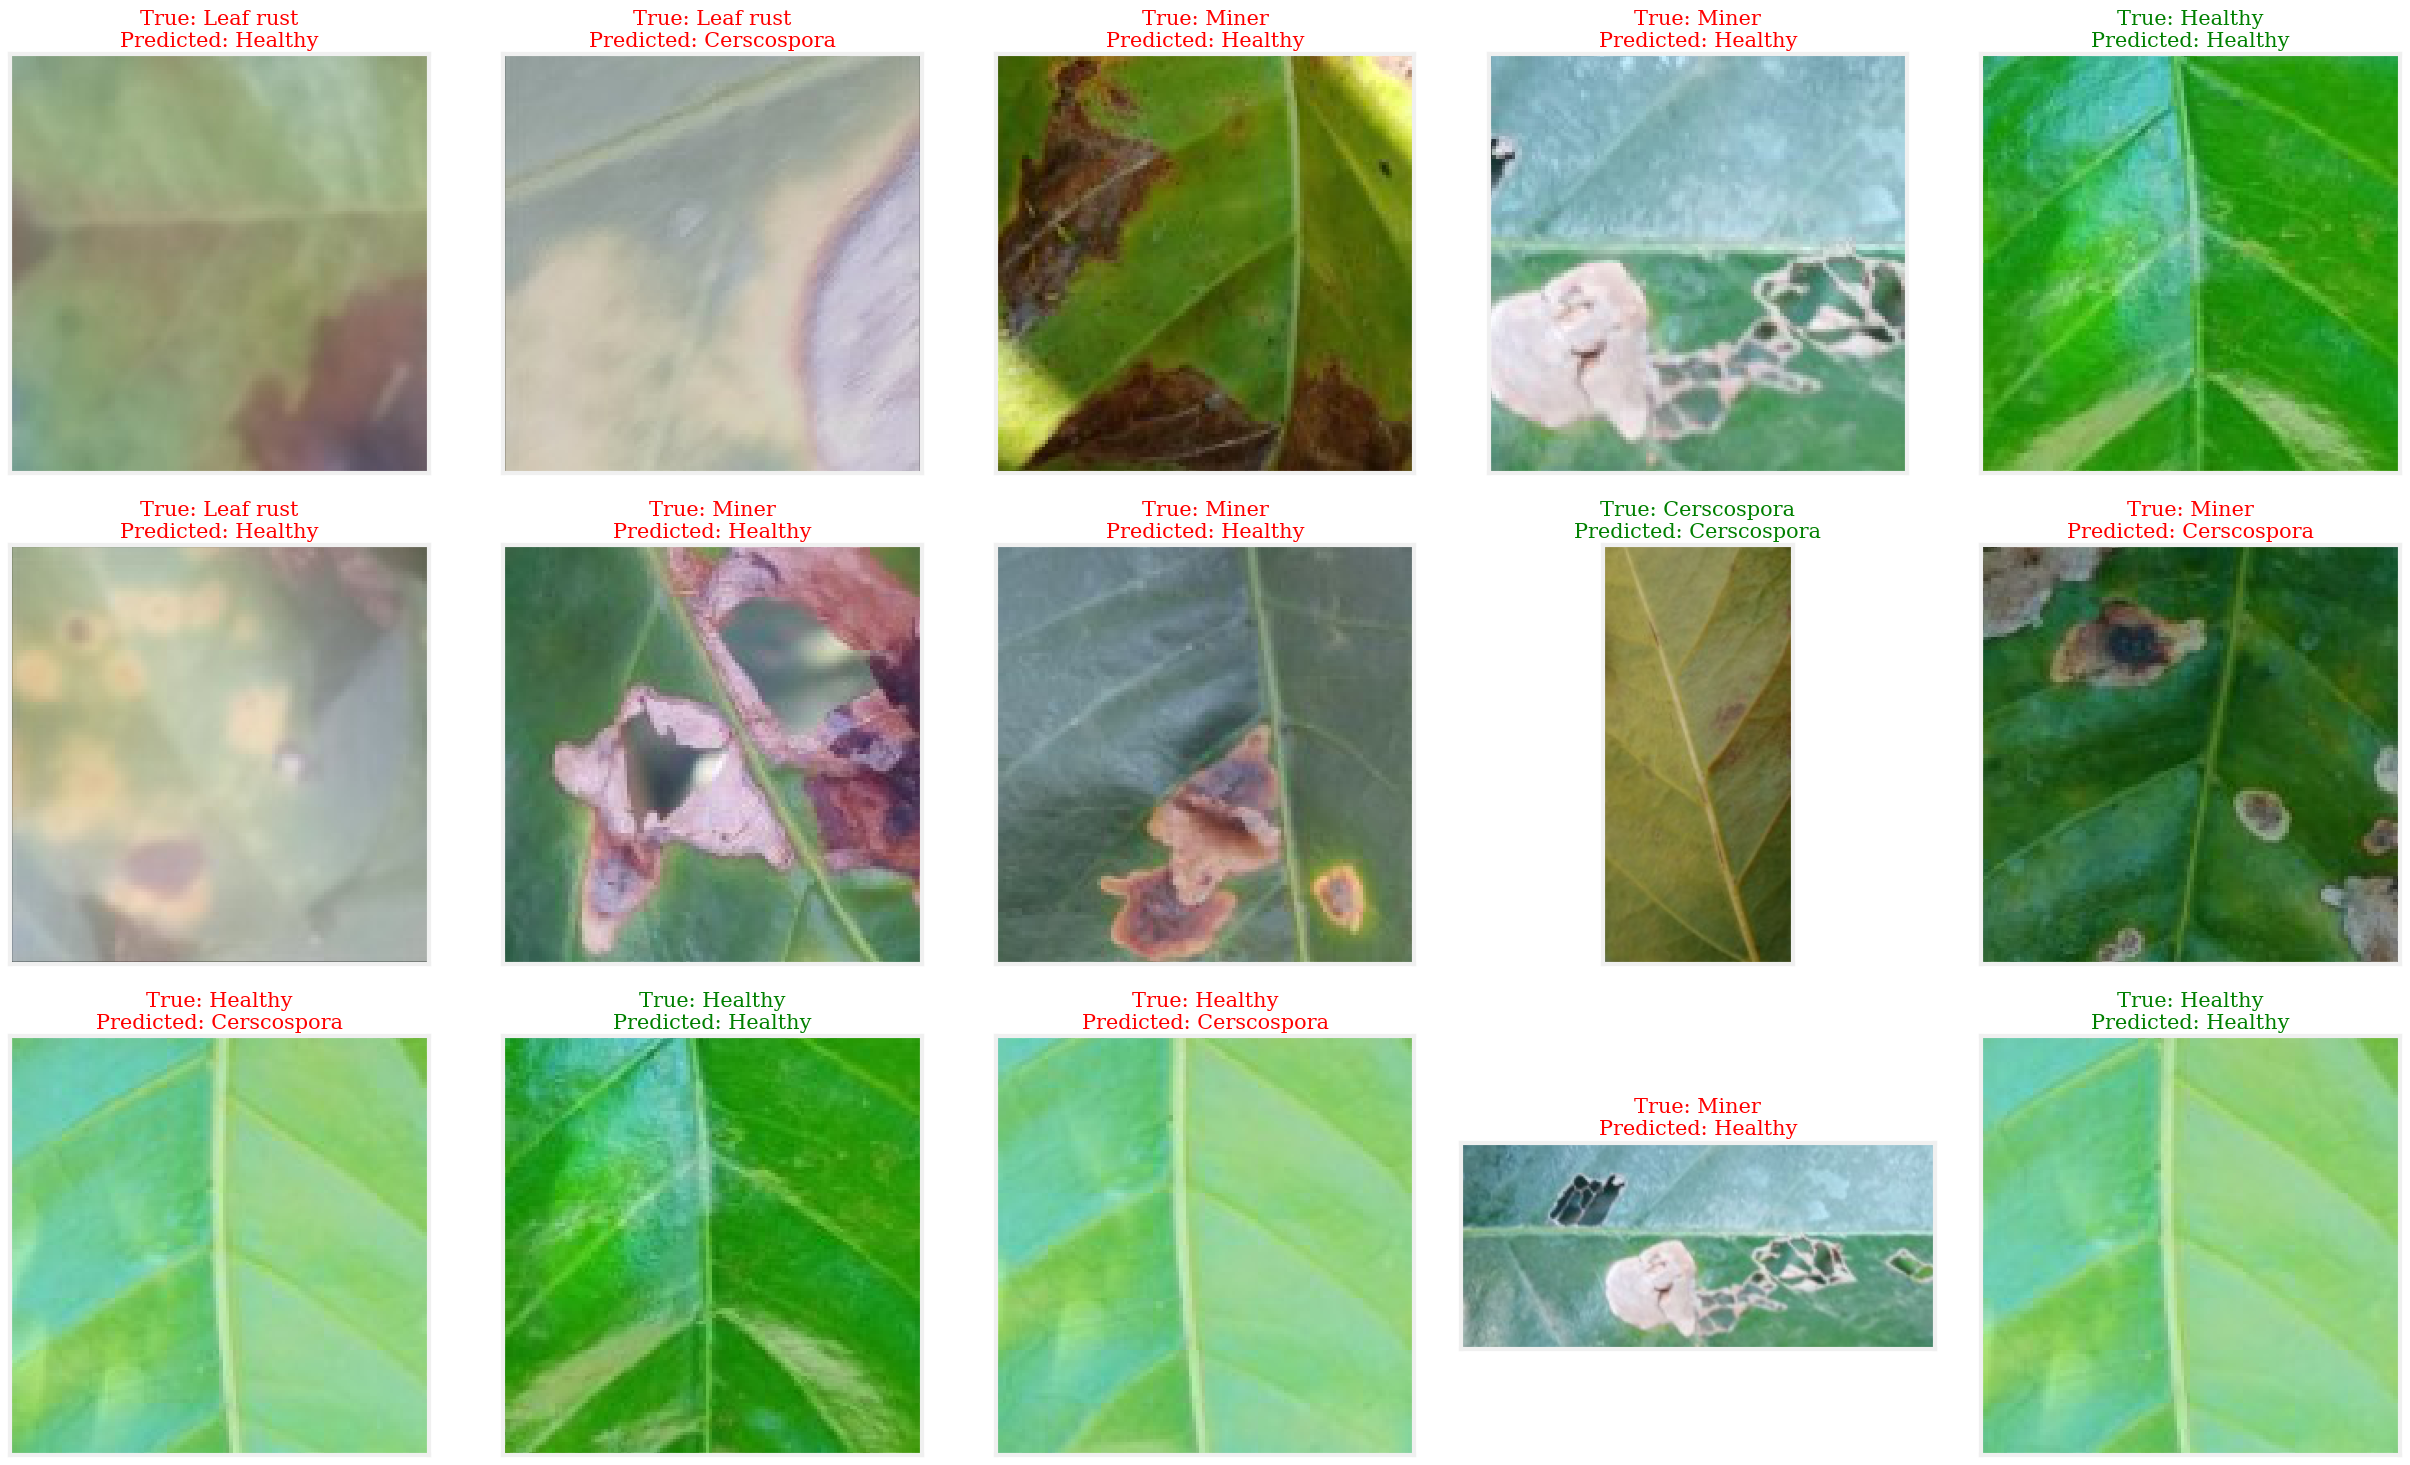

In [23]:
# Display 15 random pictures from the dataset with their labels and predictions
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

3651/3651 [==============================] - 14769s 4s/step
The first 5 predictions: ['Cerscospora', 'Cerscospora', 'Cerscospora', 'Cerscospora', 'Cerscospora']


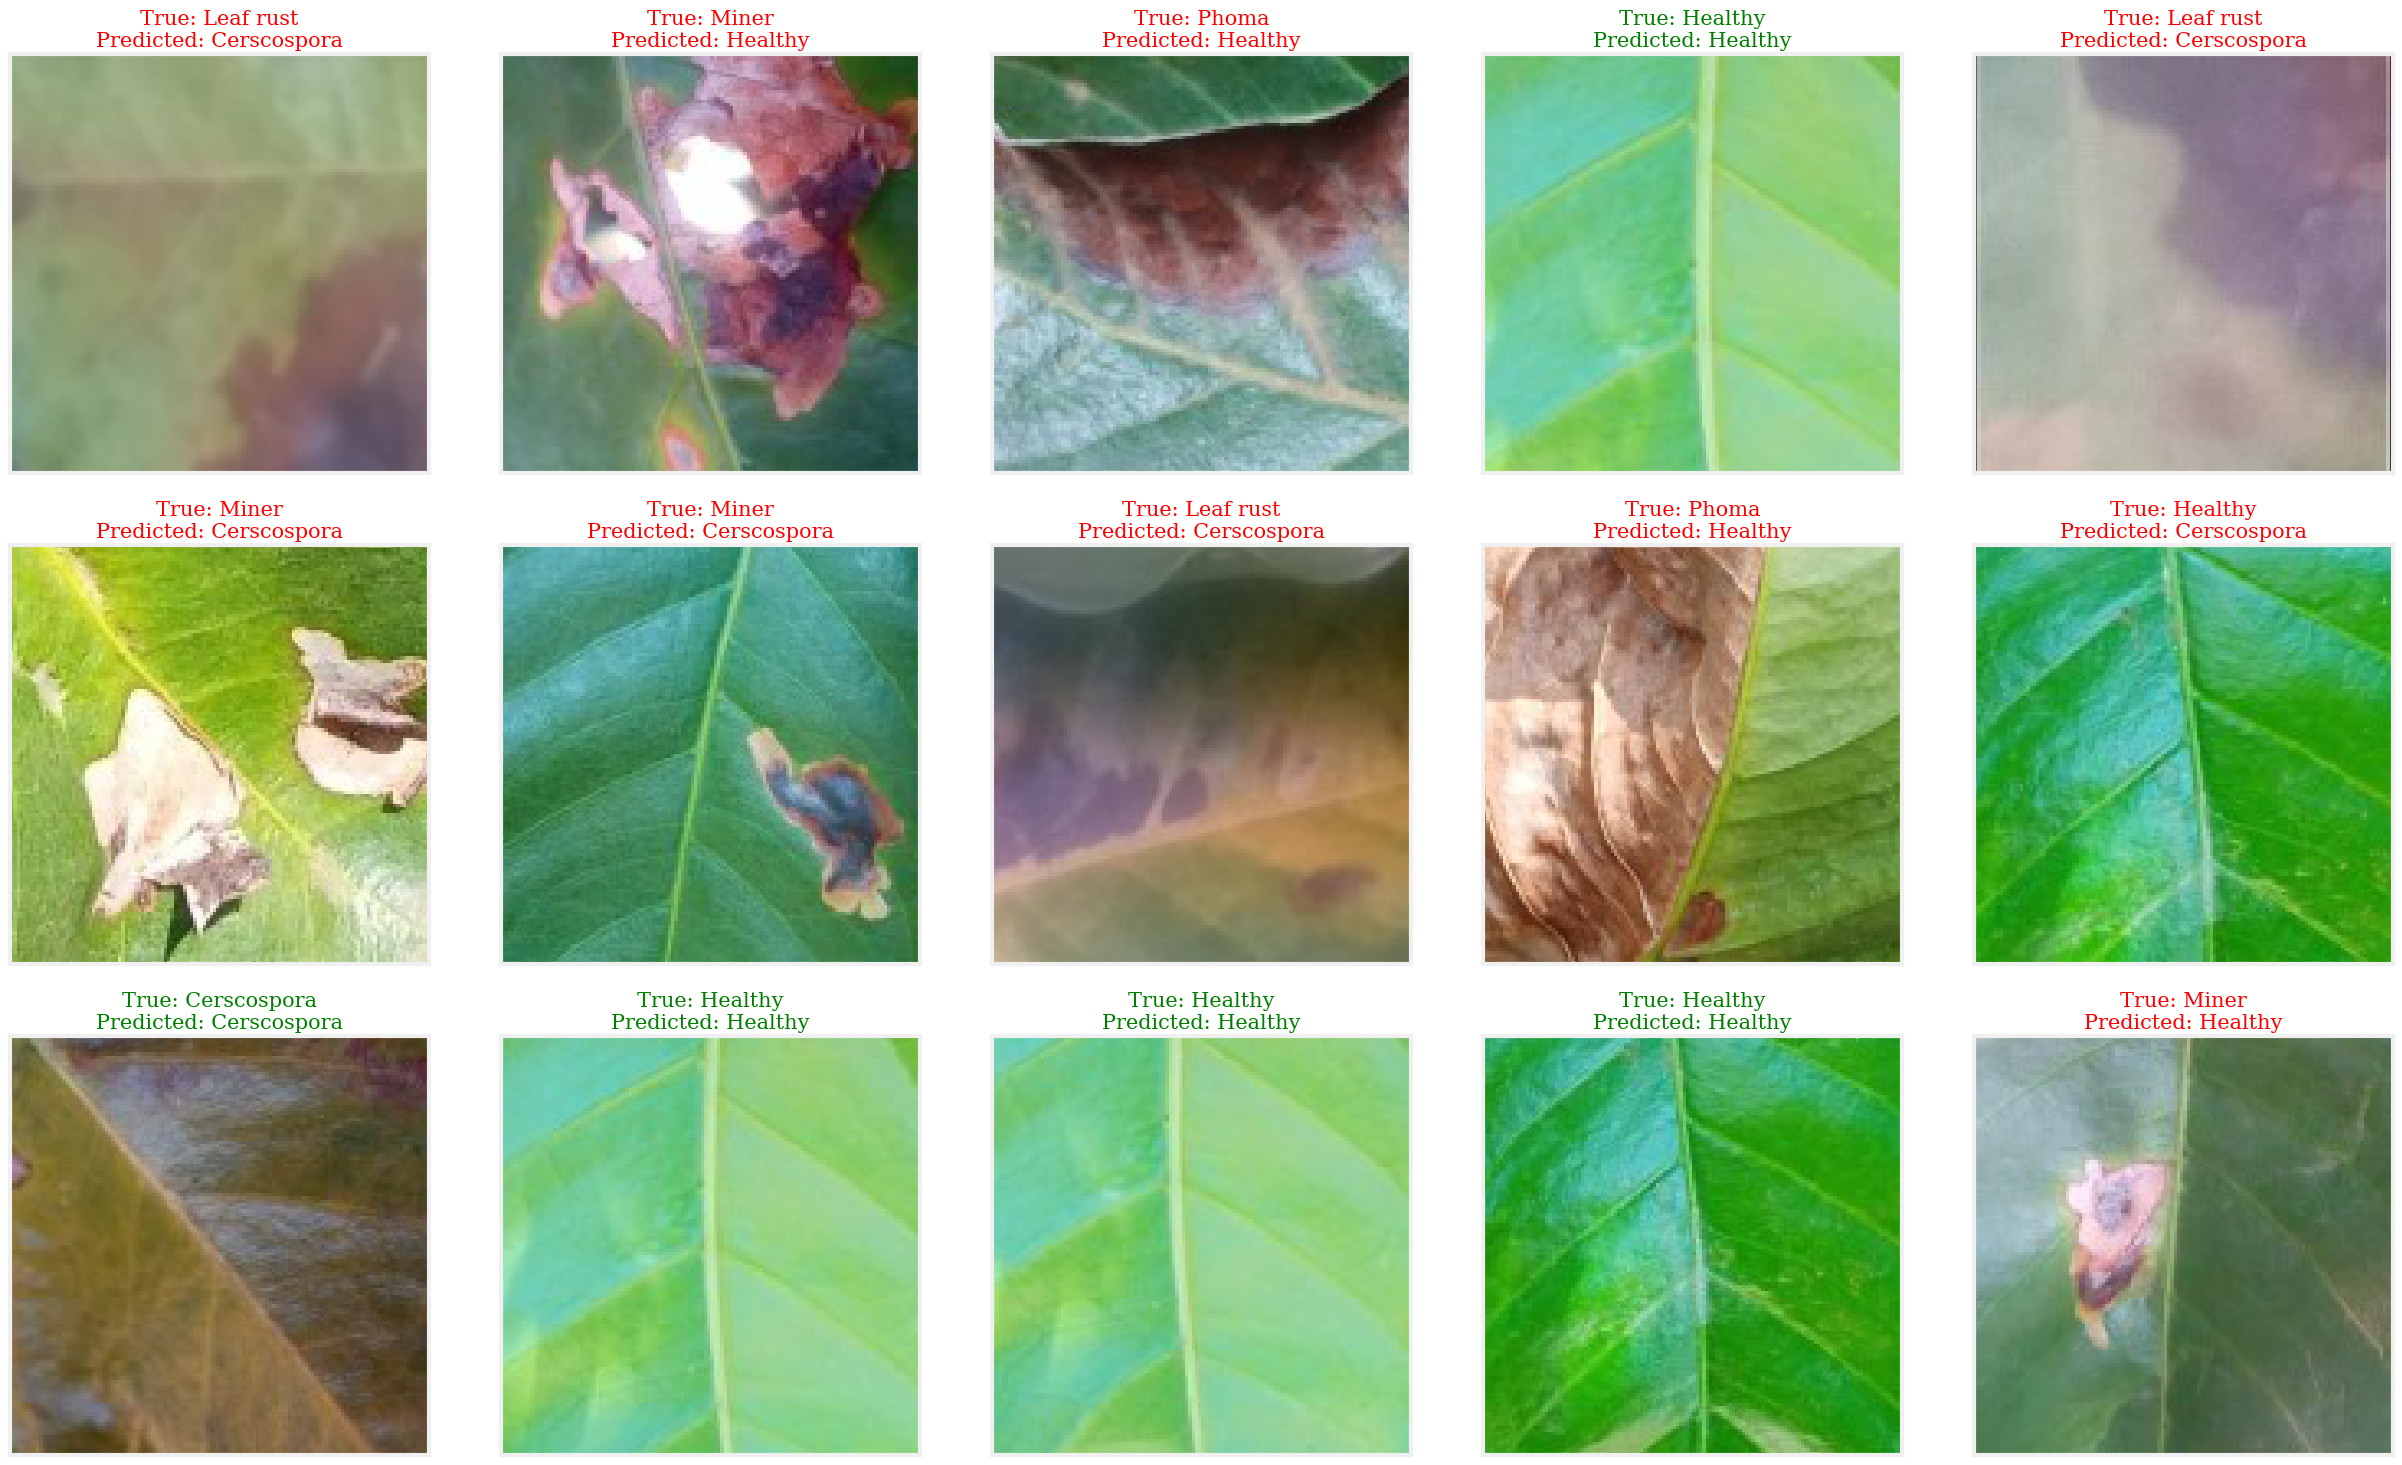

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.tight_layout()
plt.show()

Class Cerscospora:
Precision: [0.13402106 0.13565942 1.        ]
Recall: [1.         0.33280102 0.        ]
Average Precision: 0.13

Class Healthy:
Precision: [0.32184744 0.3231299  1.        ]
Recall: [1.        0.6738928 0.       ]
Average Precision: 0.32

Class Leaf rust:
Precision: [0.14065577 1.        ]
Recall: [1. 0.]
Average Precision: 0.14

Class Miner:
Precision: [0.29256913 1.        ]
Recall: [1. 0.]
Average Precision: 0.29

Class Phoma:
Precision: [0.1109066 1.       ]
Recall: [1. 0.]
Average Precision: 0.11



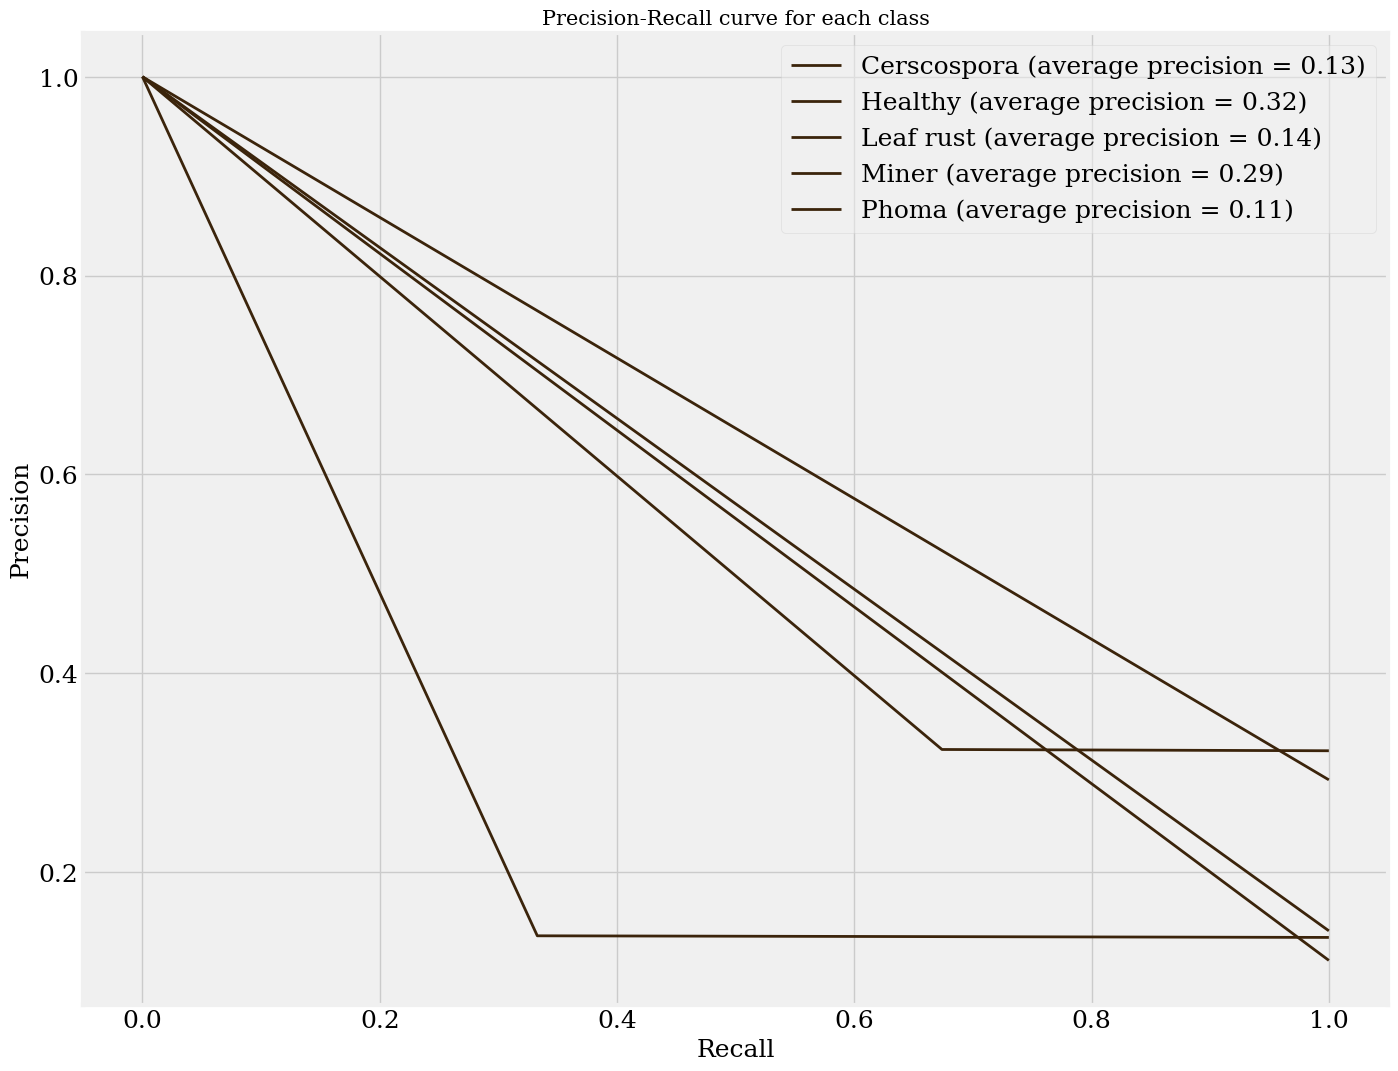

In [27]:
# Ensure the true and predicted labels have the same number of samples
min_samples = min(len(y_true_onehot), len(y_pred_onehot))
y_true_onehot = y_true_onehot[:min_samples]
y_pred_onehot = y_pred_onehot[:min_samples]

# Plot PR curve for each class
n_classes = y_true_onehot.shape[1]
plt.figure(figsize=(15, 12))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_pred_onehot[:, i])
    
    # Printing the precision and recall values for each class using the actual class names
    print(f"Class {class_names[i]}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print(f"Average Precision: {average_precision[i]:.2f}\n")
    
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall curve for each class")
plt.grid(True)
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Ensure the true labels and predicted labels have the same number of samples
min_samples = min(len(y_test), len(pred))
y_test = y_test[:min_samples]
pred = pred[:min_samples]

# Compute the classification report
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score       support
Cerscospora    0.135659  0.332801  0.192749   3131.000000
Healthy        0.323130  0.673893  0.436810   7519.000000
Leaf rust      0.000000  0.000000  0.000000   3286.000000
Miner          0.000000  0.000000  0.000000   6835.000000
Phoma          0.000000  0.000000  0.000000   2591.000000
accuracy       0.261493  0.261493  0.261493      0.261493
macro avg      0.091758  0.201339  0.125912  23362.000000
weighted avg   0.122180  0.261493  0.166419  23362.000000


C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


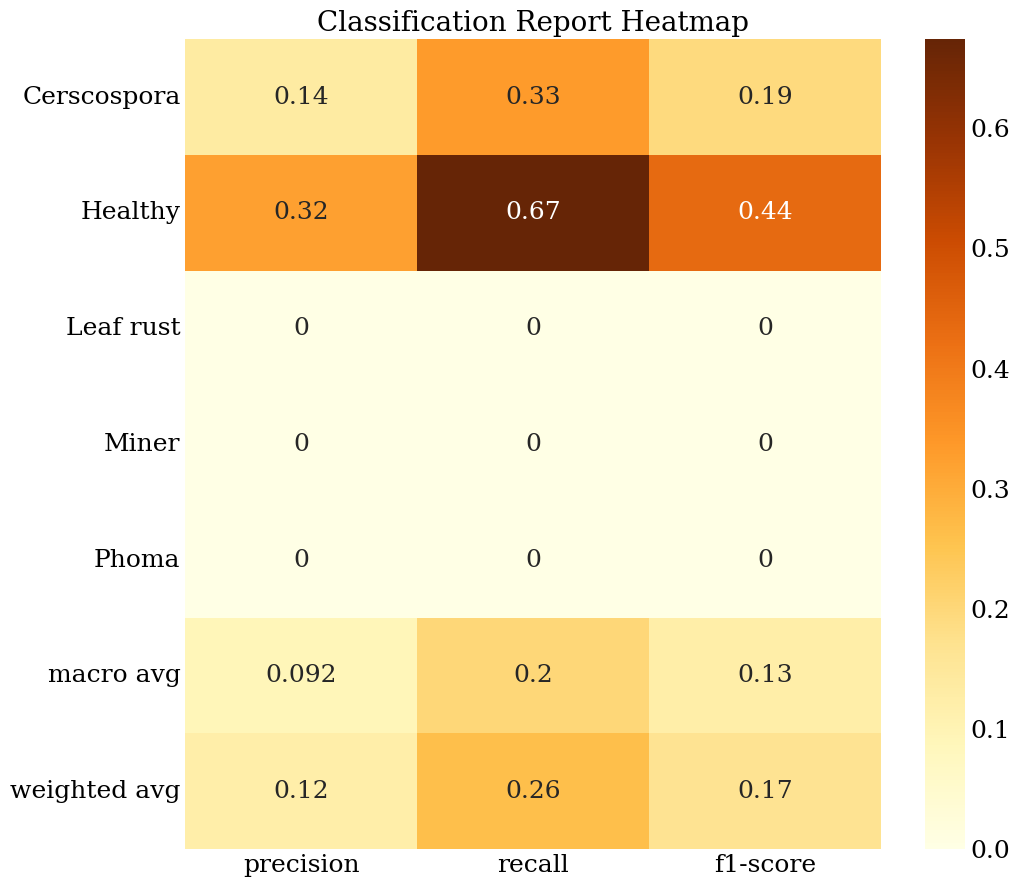

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove the 'accuracy' row
df = df.drop(['accuracy'])

# Remove the 'support' column
df = df.drop(['support'], axis=1)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, cmap='YlOrBr')
plt.title('Classification Report Heatmap', fontsize=20)
plt.show()

In [37]:
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 14), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(20, 14)).
        text_size: Size of output figure text (default=10).
        norm: Normalize values or not (default=False).
        savefig: Save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] if norm else cm

    # Determine the number of classes
    n_classes = cm.shape[0]

    # Plot the figure
    plt.figure(figsize=figsize)
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.colorbar()

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(n_classes)

    # Label the axes
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=text_size)
    plt.yticks(tick_marks, labels, fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}{' (' + str(round(cm_norm[i, j]*100, 1)) + '%)' if norm else ''}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    # Label the axes
    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

    # Save the figure if required
    if savefig:
        plt.savefig("confusion_matrix.png")

    plt.show()

# Example usage:
# make_confusion_matrix(y_test, pred, classes=list(labels.values()))

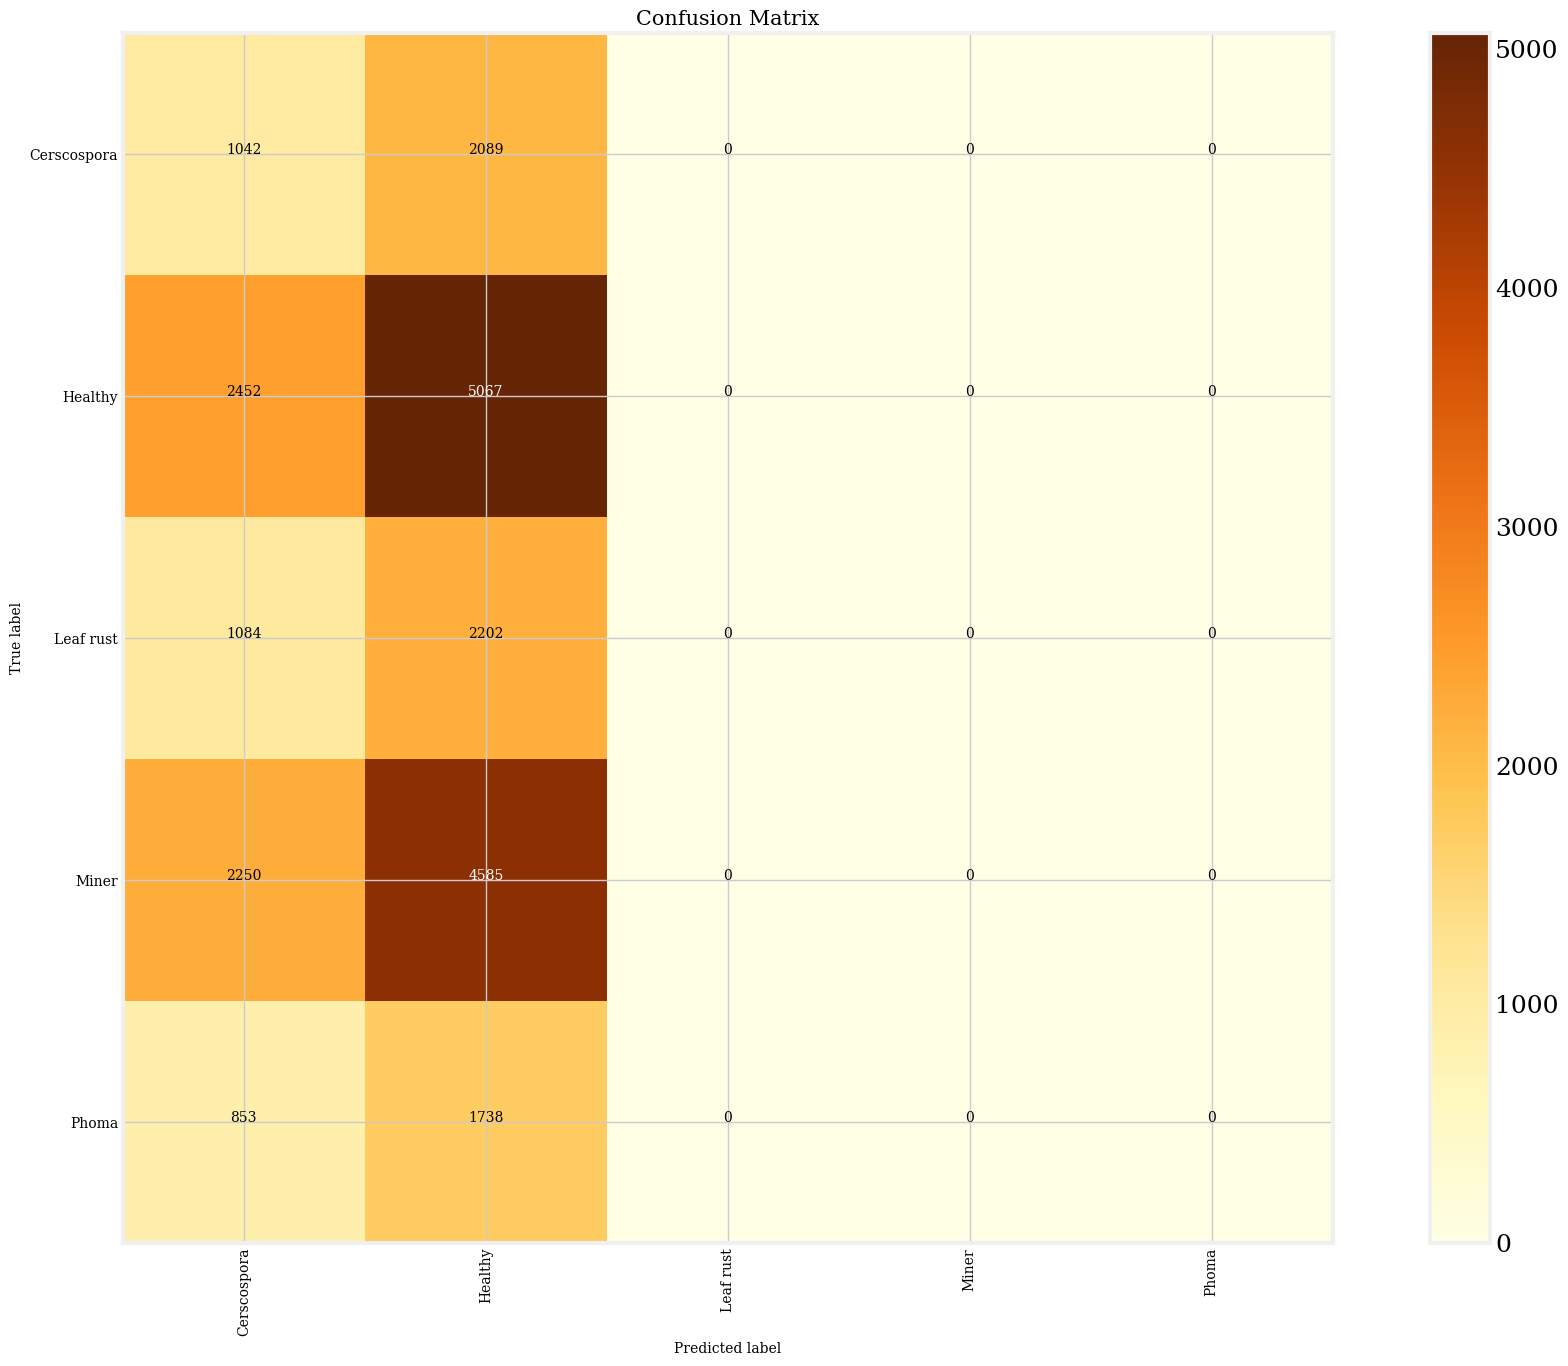

In [38]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [46]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch" of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming 'model' is your trained model and 'img_path' is the path to the image
# img_array = get_img_array(img_path, size=img_size[:2])
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
# save_and_display_gradcam(img_path, heatmap)

In [47]:
from sklearn.metrics import classification_report

# Assuming 'y_test' contains the true labels and 'pred' contains the predicted labels
print(classification_report(y_test, pred))

C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Cerscospora       0.14      0.33      0.19      3131
     Healthy       0.32      0.67      0.44      7519
   Leaf rust       0.00      0.00      0.00      3286
       Miner       0.00      0.00      0.00      6835
       Phoma       0.00      0.00      0.00      2591

    accuracy                           0.26     23362
   macro avg       0.09      0.20      0.13     23362
weighted avg       0.12      0.26      0.17     23362



C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tanusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#END